This notebook is a work through for the implementation of a basic BM25 algorithm.

In [7]:
import os
import nltk
nltk.download('popular');
from nltk.corpus import stopwords
# from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import numpy as np
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to C:\Users\Duc Minh
[nltk_data]    |     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to C:\Users\Duc Minh
[nltk_data]    |     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to C:\Users\Duc Minh
[nltk_data]    |     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to C:\Users\Duc Minh
[nltk_data]    |     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to C:\Users\Duc Minh
[nltk_data]    |     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | D

Get the text document collection

In [5]:
!wget https://storage.googleapis.com/pet-detect-239118/text_retrieval/documents.zip documents.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from zipfile import ZipFile
file_name = '../documents.zip'

with ZipFile(file_name, 'r',) as zip:
  zip.extractall()
  print('Done!!')

Done!!


Parse the text document dataset into a dictionary

In [8]:
def get_docDict(path):
  doc_dict = {}
  file_names = os.listdir(path)

  for file in file_names:
    full_path = path+'/'+file
    with open(full_path, 'r', errors='ignore') as f:
      data = f.readlines()
    text = "".join([i for i in data])
    # remove all the "\n" from the text
    text = re.sub("\n", " ", text)
    doc_dict[file] = text
  return doc_dict

In [9]:
path = '../documents'
doc_dict = get_docDict(path)


Clean the text data

In [10]:
def clean_text(doc_dict):
  """
  input - a dictionary of {filename : text}
  output - a dictionary of {filename : clean text} 

  """
  clean_dict = {}
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')
  
  for name, doc in doc_dict.items():
    # remove extra white space
    text = re.sub(r"\s+", " ", doc)
    # remove extra ...
    text = re.sub(r"\.+"," ", doc)
    # remove hyphen
    text = re.sub(r"-","", text)
    text = text.lower()
    text_tokens = word_tokenize(text)
    text_clean = []
    for word in text_tokens:
      if (word not in stopwords_english and word not in string.punctuation):
        stem_word = stemmer.stem(word)
        text_clean.append(word)
    
    clean_dict[name] = text_clean
    
  return clean_dict

In [11]:
clean_dict = clean_text(doc_dict)
clean_dict['A00-1000.pdf.txt'][:5]

['association', 'computational', 'linguistics', '6', 'th']

Build the dataset vocabulary

In [12]:
def make_vocab(doc_dict):
  """
  input - a dictionary of {filename : clean text} 
  output - a set of unique terms forms the dataset vocabulary
  """
  total_tokens = []
  for tokens in doc_dict.values():
    total_tokens += tokens
  vocab = list(set(total_tokens))
  print(doc_dict)
  return vocab

In [ ]:
vocab = make_vocab(clean_dict)
len(vocab)


In [14]:
vocab = make_vocab(clean_dict)

{'A00-1000.pdf.txt': ['association', 'computational', 'linguistics', '6', 'th', 'applied', 'natural', 'language', 'processing', 'conference', 'proceedings', 'conference', 'april', '29may', '4', '2000', 'seattle', 'washington', 'usa', 'anlp', '2000preface', '131', 'papers', 'submitted', 'anlp2000', '46', 'accepted', 'presentation', 'conference', 'papers', 'came', '24', 'countries', 'fifty', 'eight', 'united', 'states', 'america', 'eleven', 'germany', 'united', 'kingdom', 'nine', 'canada', 'eight', 'japan', 'four', 'italy', 'spain', 'three', 'ach', 'france', 'korea', 'switzerland', 'two', 'australia', 'china', 'netherlands', 'sweden', 'one', 'czech', 'republic', 'denmark', 'finland', 'greece', 'india', 'hong', 'kong', 'malaysia', 'norway', 'russia', 'taiwan', '40', 'papers', 'submitted', 'industry', '85', 'papers', 'came', 'academia', '2', 'papers', 'submitted', 'government', 'organizations', 'four', 'submissions', 'combined', 'reviewing', 'process', 'supported', 'webbased', 'reviewer', 

Calculate TF-IDF

In [5]:
# compute document-wise term frequency

def get_DocTF(doc_dict, vocab):
  """
  input - a dictionary of {filename : clean text}, the vocabulary of the whole dataset
  output - a dictionary of {filename : {term : count}}
  """
  tf_dict = {}
  # make the dict for filename=>{term:frequency}
  for doc_id in doc_dict.keys():
    tf_dict[doc_id] = {}

  for word in vocab:
    for doc_id, text in doc_dict.items():
      tf_dict[doc_id][word] = text.count(word)
    
  return tf_dict

In [21]:
tf_dict = get_DocTF(clean_dict, vocab)

In [2]:
# compute document frequency

def get_DocDF(clean_dict, vocab):
  """
  input - a dictionary of {filename : clean text}, the vocabulary of the whole dataset
  output - a dictionary of all terms in the vocabulary - {term : count}
  """
  df_dict = {}
  for word in vocab:
    freq = 0
    for text_tokens in clean_dict.values():
      if word in text_tokens:
        freq += 1
    df_dict[word] = freq

  return df_dict

In [20]:
# return a dictionary of how many documents do term exists in
df_dict = get_DocDF(clean_dict, vocab)

In [18]:
# compute IDF

def inverse_DF(df_dict, vocab, N):
  """
  input - a dictionary of DF {term : count}, the vocabulary of the whole dataset, total # of documents in the dataset
  output - a dictionary of IDF of all terms in the vocabulary - {term : inver_df}
  """
  idf_dict = {}

  for word in vocab:
    N_q = df_dict[word]
    # idf_dict[word] = np.log10(N / N_q) 
    idf_dict[word] = np.log(((N - N_q + 0.5) / (N_q + 0.5)) + 1)
       
  return idf_dict

In [22]:
N = len(tf_dict.keys())
idf_dict = inverse_DF(df_dict, vocab, N)
print(idf_dict)

{'describe': 0.4168938039317871, 'nord': 2.174751721484161, 'specified': 0.7396671961948382, 'reacting': 2.6855773452501515, 'moving': 2.174751721484161, '17': 1.0761394328160512, 'denoted': 2.6855773452501515, 'ungrammatical': 2.174751721484161, 'perzanowski': 2.6855773452501515, 'predicts': 2.6855773452501515, 'avenue': 2.6855773452501515, 'intrasentence': 2.6855773452501515, 'abigail': 2.6855773452501515, 'inv': 2.6855773452501515, '204': 2.6855773452501515, 'fulkerson': 2.174751721484161, 'consistent': 2.6855773452501515, 'provider': 2.174751721484161, 'rep': 2.174751721484161, 'fast': 1.586965056582042, '40e': 2.6855773452501515, '~r~n': 2.6855773452501515, 'numbers': 1.8382794848629478, '163': 2.6855773452501515, 'hampton': 2.6855773452501515, 'bourne': 2.6855773452501515, '01012001': 2.6855773452501515, 'static': 2.6855773452501515, 'understands': 2.6855773452501515, 'presupposi': 2.6855773452501515, 'controlled': 1.8382794848629478, 'couples': 2.6855773452501515, 'guis': 2.6855

In [18]:
idf_dict['language']

0.02298951822469878

In [15]:
# compute the TF-IDF dictionary 

def get_tf_idf(tf_dict, idf_dict, doc_dict, vocab):
  tf_idf_dict = {}
  for doc_id in doc_dict.keys():
    tf_idf_dict[doc_id] = {}
  
  for word in vocab:
    for doc_id, text_tokens in doc_dict.items():
      tf_idf_dict[doc_id][word] = round((tf_dict[doc_id][word] * idf_dict[word]), 4)
  return tf_idf_dict

In [23]:
tf_idf_dict = get_tf_idf(tf_dict, idf_dict, doc_dict, vocab)
tf_idf_dict['A00-1001.pdf.txt']['language']

0.5288

To use the BM25 algorithm, we still need to compute TF and IDF. 

The **TF** component includes the query frequency, and total number of terms as with TF-IDF, but we add two special parameters `k` and `b` which we can use to optimize our algorithm, but by default we stick with the values of `1.2` and `0.75` respectively. We also include two new values:
* Average document length (avgdl) - the average length of *all* documents
* *D* - the length of the current document.

Our new **IDF** component is similar, it maintains the parametes `N` and `N_q`, which are the number of documents and the number of documents *that contain* our query, respectively. And all we do is add a few values (0.5, 1) here and there.

In [37]:
# compute average document length (use the cleaned text)

def get_avgdl(clean_dict):
  total_doc = len(clean_dict.keys())
  total_length = 0
  for text in clean_dict.values():
    total_length += len(text)

  avgdl = total_length / total_doc

  return round(avgdl, 4)

In [38]:
avgdl = get_avgdl(clean_dict)
avgdl

2771.4762

# Implement the BM25 algorithm
* compute a dictionary of a score of a given term from a given document
* the total score of a given document is presented as
\begin{align}
    BM25(d)=\sum_{t=q, f_t,_d >0} log(1 + \frac{N-df_t+0.5}{df_t+0.5}) \cdot \frac{f_t,_d}{f_t,_d + K \cdot (1-b+b\frac{l(d)}{avgdl}) }
\end{align}

*d* - document, *t* - term, *q* - word from the query, *N* - total number of documents

$f_t,_d$ - term frequenct (TF) given a word from query, $df_t$ - document frequency of a given term

$l(d)$ - total length of a given document d, $avgdl$ - average length of document in the dataset

In [40]:
# compute BM25 score dictionary

def bm25(tf_dict, clean_dict, df_dict, vocab, k=1.2, b=0.75):
  bm25_dict = {}
  avgdl = get_avgdl(clean_dict)
  N = len(clean_dict.keys())
  
  # create the collection of dictionaries of all documents
  for doc_id in clean_dict.keys():
    bm25_dict[doc_id] = {}

  for word in vocab:
    for doc_id, text_tokens in clean_dict.items():
      freq = tf_dict[doc_id][word]
      # the TF in BM25
      tf = (freq*(k+1)) / (freq + k*(1-b+b*len(clean_dict[doc_id])/avgdl))
      # get DF
      N_q = df_dict[word]
      idf = np.log(((N - N_q + 0.5) / (N_q + 0.5)) + 1)
      score = round(tf*idf,4)
      bm25_dict[doc_id][word] = score

  return bm25_dict

In [41]:
bm25_dict = bm25(tf_dict, clean_dict, df_dict, vocab)

In [42]:
bm25_dict['A00-1020.pdf.txt']['language']

0.0415

# Define the BM25 Model (Probabilistic Model)
* To find the most relevant documents related to the query
* Pass the query along with the document set (dictionary) and the BM25 scores of all words in the vocabulary
* Returns the top 5 documents ID and scores 


In [43]:
def BM25Model(query, doc_dict, bm25_dict):
  query_vocab = []
  query = query.lower()
  query = re.sub(r"\s+", " ", query)
  stopwords_english = stopwords.words('english')

  for word in query.split():
    if (word not in string.punctuation and word not in stopwords_english):
        query_vocab.append(word)

  query_wc = {}
  for word in query_vocab:
    query_wc[word] = query.split().count(word)

  relevance_scores = {}
  # use the raw doc_dict to get the filename only
  for doc_id in doc_dict.keys():
    score = 0
    for word in query_vocab:
      score += query_wc[word] * bm25_dict[doc_id][word]
    relevance_scores[doc_id] = round(score,4)

  # sort the relevance score and get the top-k ranking
  # sort the keys of the relevance score by value
  sort_keys = sorted(relevance_scores, key=relevance_scores.get , reverse = True)
  top_keys = sort_keys[:5]
  top_5 = {}
  for key in top_keys:
    top_5[key] = relevance_scores[key]

  return top_5

The vector space model (VSM)

In [44]:
def get_tf_idf(tf_dict, idf_dict, doc_dict, vocab):
  tf_idf_dict = {}
  for doc_id in doc_dict.keys():
    tf_idf_dict[doc_id] = {}
  
  for word in vocab:
    for doc_id, text_tokens in doc_dict.items():
      tf_idf_dict[doc_id][word] = round((tf_dict[doc_id][word] * idf_dict[word]), 4)
  return tf_idf_dict


def vectorSpaceModel(query, doc_dict,tfidf_dict):
  query_vocab = []
  query = query.lower()
  query = re.sub(r"\s+", " ", query)
  stopwords_english = stopwords.words('english')

  for word in query.split():
    if (word not in string.punctuation and word not in stopwords_english):
        query_vocab.append(word)

  query_wc = {}
  for word in query_vocab:
    query_wc[word] = query.split().count(word)

  relevance_scores = {}
  for doc_id in doc_dict.keys():
    score = 0
    for word in query_vocab:
      score += query_wc[word] * tf_idf_dict[doc_id][word]
    relevance_scores[doc_id] = round(score,4)

  # sort the relevance score and get the top-k ranking
  # sort the keys of the relevance score by value
  sort_keys = sorted(relevance_scores, key=relevance_scores.get , reverse = True)
  top_keys = sort_keys[:5]
  top_5 = {}
  for key in top_keys:
    top_5[key] = relevance_scores[key]

  return top_5

In [45]:
tfidf_dict = get_tf_idf(tf_dict, idf_dict, doc_dict, vocab) 

In [46]:
query1 = "Natural Language"
result1 = BM25Model(query1, doc_dict, bm25_dict)
print(f'ranked by BM25: {result1}')
result2 = vectorSpaceModel(query1, doc_dict, tfidf_dict)
print(f'ranked by VSM: {result2}')

ranked by BM25: {'A00-1001.pdf.txt': 0.1977, 'A00-1007.pdf.txt': 0.1926, 'A00-1005.pdf.txt': 0.188, 'A00-1000.pdf.txt': 0.1856, 'A00-1009.pdf.txt': 0.1831}
ranked by VSM: {'A00-1001.pdf.txt': 2.2942, 'A00-1007.pdf.txt': 1.8492, 'A00-1005.pdf.txt': 1.2415, 'A00-1016.pdf.txt': 0.9508, 'A00-1009.pdf.txt': 0.9115}


In [47]:
query2 = "generative model"
result1 = BM25Model(query2, doc_dict, bm25_dict)
print(f'ranked by BM25: {result1}')
tfidf_dict = get_tf_idf(tf_dict, idf_dict, doc_dict, vocab) 
result2 = vectorSpaceModel(query2, doc_dict, tfidf_dict)
print(f'ranked by VSM: {result2}')

ranked by BM25: {'A00-1010.pdf.txt': 3.7847, 'A00-1014.pdf.txt': 2.5858, 'A00-1004.pdf.txt': 0.8908, 'A00-1019.pdf.txt': 0.8832, 'A00-1007.pdf.txt': 0.7828}
ranked by VSM: {'A00-1004.pdf.txt': 20.8447, 'A00-1019.pdf.txt': 15.0082, 'A00-1010.pdf.txt': 6.0171, 'A00-1014.pdf.txt': 4.2593, 'A00-1007.pdf.txt': 3.3352}


In [48]:
query3 = "text retrieval for nature language"
result1 = BM25Model(query3, doc_dict, bm25_dict)
print(f'ranked by BM25: {result1}')
tfidf_dict = get_tf_idf(tf_dict, idf_dict, doc_dict, vocab) 
result2 = vectorSpaceModel(query3, doc_dict, tfidf_dict)
print(f'ranked by VSM: {result2}')

ranked by BM25: {'A00-1019.pdf.txt': 4.0367, 'A00-1004.pdf.txt': 3.9596, 'A00-1018.pdf.txt': 3.1212, 'A00-1003.pdf.txt': 3.0072, 'A00-1000.pdf.txt': 2.6401}
ranked by VSM: {'A00-1003.pdf.txt': 60.3235, 'A00-1004.pdf.txt': 12.596, 'A00-1018.pdf.txt': 12.0305, 'A00-1012.pdf.txt': 11.9561, 'A00-1019.pdf.txt': 8.0488}


Visualize score versus document length

In [46]:
BM25_term_score = []
VSM_term_score = []
doc_length = []

for doc_id in doc_dict.keys():
  doc_length.append(len(clean_dict[doc_id]))
  vsm_score = np.sum([x for x in tfidf_dict[doc_id].values()])
  VSM_term_score.append(vsm_score)
  bm25_score = np.sum([x for x in bm25_dict[doc_id].values()])
  BM25_term_score.append(bm25_score)


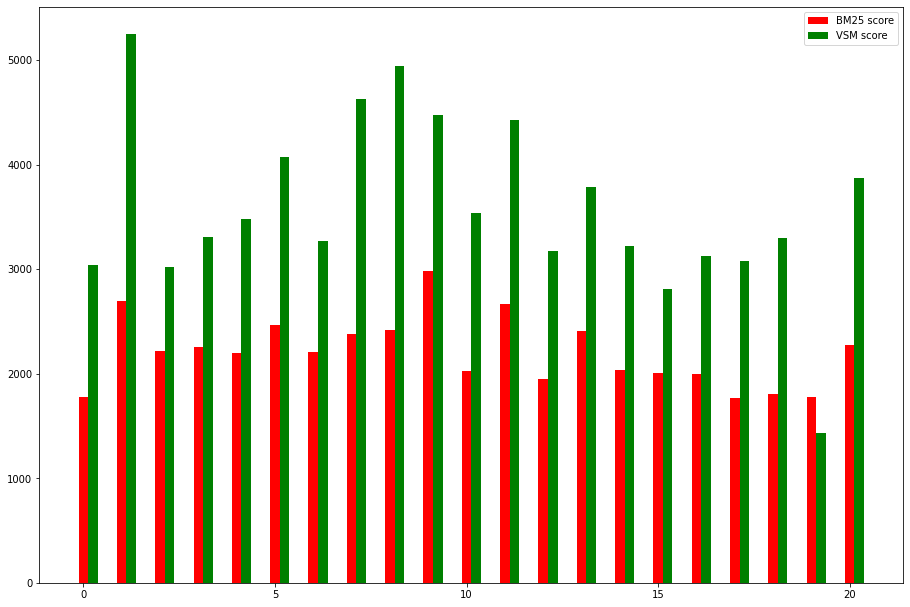

In [60]:
fig = plt.figure(figsize=(12, 8))
data = [BM25_term_score, VSM_term_score]
X = np.arange(21)

ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.legend(['BM25 score', 'VSM score'])